# Las losowy
### Parametry:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**

### Przewidujemy: *level*

In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("../..")
from training.creating_dataset import create_dataframe


df = create_dataframe()

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   level   1206 non-null   int64 
 1   book    1206 non-null   object
 2   cha     1206 non-null   int64 
 3   con     1206 non-null   int64 
 4   dex     1206 non-null   int64 
 5   int     1206 non-null   int64 
 6   str     1206 non-null   int64 
 7   wis     1206 non-null   int64 
 8   ac      1206 non-null   int64 
 9   hp      1206 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 103.6+ KB


In [3]:
df.head()

,level,book,cha,con,dex,int,str,wis,ac,hp
0,10,Pathfinder Bestiary,1,5,2,1,7,2,29,215
1,10,Pathfinder Bestiary,1,5,0,-4,9,2,28,220
2,8,Pathfinder Bestiary,-2,6,3,-4,7,3,25,175
3,17,Pathfinder Bestiary,6,5,4,6,7,5,41,315
4,1,Pathfinder Bestiary,1,1,3,-1,-5,1,16,20


###### Level

In [4]:
y = df["level"]

In [5]:
print(y)

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64


In [6]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [7]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
print(level_count)

    lvl  count
0    -1     34
1     0     27
2     1    127
3     2    121
4     3     95
5     4     82
6     5     76
7     6     72
8     7     77
9     8     68
10    9     63
11   10     58
12   11     40
13   12     41
14   13     36
15   14     33
16   15     31
17   16     25
18   17     21
19   18     21
20   19     18
21   20     24
22   21     16


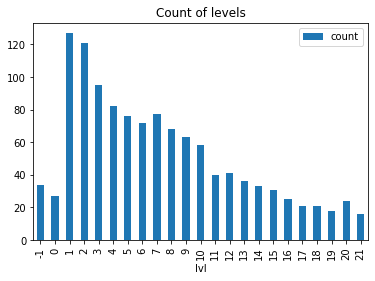

In [8]:
import matplotlib.pyplot as plt

level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Podział na zbiór treningowy i testowy

### Podział chronologiczny

In [9]:
from training.splitting_dataset import split_dataframe
import os

os.chdir("../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models")

c:\users\pauli\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Podział randomowy

In [11]:
from training.splitting_dataset import split_dataframe

(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [12]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Regresja lasem losowym

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [14]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 2.23
RMSE: 1.49


RMSE jest duże, zobaczymy zmianę wyników po tuningu.

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 1.22
RMSE test: 1.49


Nie ma overfittingu.

## Tuning

In [17]:
def assess_regression_model(model, X_train, X_test, y_train, y_test) -> None:
    # predict for train and test
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    # calculate train and test RMSE
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    # print train and test RMSE
    print(f"RMSE train: {rmse_train:.2f}")
    print(f"RMSE test: {rmse_test:.2f}")

### Tuning Lasu

In [18]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [19]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   1.9s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.2s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.2s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.2s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.3s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_

[CV] END ..max_depth=110, max_features=0.4, n_estimators=700; total time=   0.4s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   0.3s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   0.4s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   0.5s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   0.4s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=50, ma

[CV] END ...max_depth=20, max_features=0.4, n_estimators=500; total time=   0.2s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.0s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.0s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.0s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.2s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.2s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.2s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   0.4s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   0.4s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   0.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   0.5s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   0.4s
[CV] END ...max_depth=20, ma

{'n_estimators': 100, 'max_features': 0.5, 'max_depth': 20}

In [20]:
assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.17
RMSE test: 0.67


### Próba zmniejszenia overfittingu
Zmniejszam max_depth, żeby drzewo nie było zbyt głębokie.

Ustawiam max_depth na 7.

In [21]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=100, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.29
RMSE test: 0.70


Overfitting jest mniejszy.

### Sprawdzenie wyników po zaokrągleniu

In [22]:
from copy import deepcopy

predict = rf.predict(X_test)
round_predict = np.round(predict).astype("int")
round_predict = np.where(round_predict > 20, 21, round_predict)

In [23]:
from sklearn.metrics import mean_absolute_error


def check_predictions(y, y_pred):
    print(f"Mean square error: {mean_squared_error(y, y_pred):.2f}")
    print(f"RMSE: {mean_squared_error(y, y_pred, squared=False):.2f}")
    print(f"Mean absolute error = {mean_absolute_error(y, y_pred):.2f}")
    print()

In [24]:
print("Normal:")
check_predictions(y_test, predict)

print("Round:")
check_predictions(y_test, round_predict)

Normal:
Mean square error: 0.49
RMSE: 0.70
Mean absolute error = 0.47

Round:
Mean square error: 0.52
RMSE: 0.72
Mean absolute error = 0.38



### Macierz sąsiedztwa

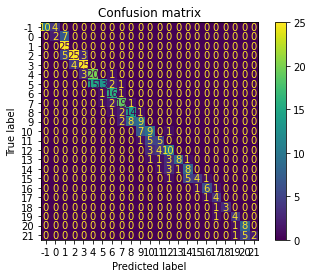

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, round_predict)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix")
plt.show()

#### Silniejsze zaokrąglenie w górę
Często predykcja jest zaniżona. Sprawdzimy wyniki z silniejszym zaokrąglaniem w górę.

In [26]:
round_predict_more_up = np.where(
    (predict % 1) > 0.33, np.ceil(predict), np.floor(predict)
).astype("int")

In [27]:
print("Normal:")
check_predictions(y_test, predict)

print("Round:")
check_predictions(y_test, round_predict)

print("Round more up:")
check_predictions(y_test, round_predict_more_up)

Normal:
Mean square error: 0.49
RMSE: 0.70
Mean absolute error = 0.47

Round:
Mean square error: 0.52
RMSE: 0.72
Mean absolute error = 0.38

Round more up:
Mean square error: 0.48
RMSE: 0.69
Mean absolute error = 0.36



Faktycznie wyniki wychodzą lepiej

#### Macierz sąsiedztwa, dla silniejszego zaokrąglania w górę

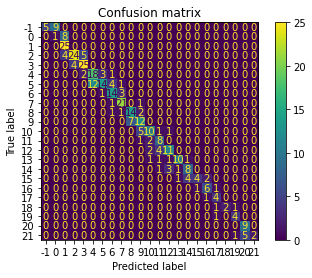

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, round_predict_more_up)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix")
plt.show()

## To samo dla randomowego splitu

### Tuning Lasu

In [29]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

print(hyper_params)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}


In [30]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   0.5s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.2s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.2s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.2s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=70, max_features=0.5, n_

[CV] END ..max_depth=110, max_features=0.4, n_estimators=700; total time=   0.5s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ..max_depth=100, max_features=0.3, n_estimators=200; total time=   0.1s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=30, max_features=0.5, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   0.4s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   0.5s
[CV] END ...max_depth=80, max_features=0.3, n_estimators=700; total time=   0.5s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   0.4s
[CV] END ...max_depth=50, max_features=0.2, n_estimators=600; total time=   0.5s
[CV] END ...max_depth=50, ma

[CV] END ...max_depth=20, max_features=0.4, n_estimators=500; total time=   0.3s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.0s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.0s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=100; total time=   0.0s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.2s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.2s
[CV] END ...max_depth=60, max_features=0.3, n_estimators=300; total time=   0.3s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   0.5s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   0.6s
[CV] END ...max_depth=80, max_features=0.4, n_estimators=700; total time=   0.5s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   0.6s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=800; total time=   0.5s
[CV] END ...max_depth=20, ma

{'n_estimators': 400, 'max_features': 0.5, 'max_depth': 40}

In [31]:
assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.17
RMSE test: 0.49


### Próba zmniejszenia overfittingu
Ustawiam max_depth na 7.

In [32]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=400, max_features=0.5, max_depth=7
)
rf.fit(X_train, y_train)
assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.44
RMSE test: 0.47


### Sprawdzenie wyników po zaokrągleniu

In [33]:
from copy import deepcopy

predict_random_split = rf.predict(X_test_random_split)
round_predict_random_split = np.round(predict_random_split).astype("int")
round_predict_random_split = np.where(
    round_predict_random_split > 20, 21, round_predict_random_split
)

#### Silniejsze zaokrąglenie w górę

In [34]:
round_predict_more_up_random_split = np.where(
    (predict_random_split % 1) > 0.33,
    np.ceil(predict_random_split),
    np.floor(predict_random_split),
).astype("int")

In [35]:
print("Normal:")
check_predictions(y_test_random_split, predict_random_split)

print("Round:")
check_predictions(y_test_random_split, round_predict_random_split)

print("Round:")
check_predictions(y_test_random_split, round_predict_more_up_random_split)

Normal:
Mean square error: 0.22
RMSE: 0.47
Mean absolute error = 0.29

Round:
Mean square error: 0.25
RMSE: 0.50
Mean absolute error = 0.20

Round:
Mean square error: 0.24
RMSE: 0.49
Mean absolute error = 0.21



### Macierz sąsiedztwa

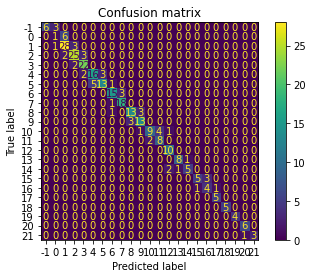

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_random_split, round_predict_more_up_random_split)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(-1, 22))

disp.plot()
plt.title("Confusion matrix")
plt.show()

### Podsumowanie:

* Wyniki zadowalające.
* Wyniki poprawiły się względem regesji liniowej.
* Dla podziału chronologicznego dostajemy słabe dopasowanie dla danych testowych. Być może dla większej ilości książek będzie lepiej.